# $~~~~~~~~~~~~~~~~~~~~\color{black}{\text{Jean N'dah Kouagou}}$


###  $~~~~~~~~~~~~~~~~~\color{blue}{\text{Foundation of Machine Learning}} $

#### $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ \color{green}{\underline{\text{Project 1}}}$

$\color{black}{\text{Introduction}}$

In this project, we implement three machine learning algorithms: Naive Bayes, Softmax Logistic Regression and Gaussian Discriminant Analysis. The three algorithms are used for classificaction and are tested on the same data set for comparison. Some nice observations have been made which we summarise at the bottom of this notebook.

In [1]:
#!pip3 install progress_bar

In [1]:
import numpy as np, pandas as pd, seaborn as sns, progress_bar as pb

In [2]:
from sklearn.preprocessing import LabelEncoder as le
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

## Naive Bayes

In [3]:
class Naive_Bayes(object):
    def __init__(self):
        pass
    
    def Phi_ki(self, i, k):
        """This function is a method to compute the probabilities P(X^(i)=1/y=k)"""
        Res1=np.sum((self.features.iloc[:, i] == 1) & (self.target==k))+1 # adding 1 for 
        #Laplace smoothing
        Res2=np.sum(self.target==k)
        Res3=self.target.nunique()# considering Res3 in the denominator still for
        #Laplace smoothing
        return Res1/(Res2+Res3)
    
    def train(self, features, target): 
        # Providing data for training
        self.features=features
        self.target=target
        # Computing the probabilities P(y=k)
        self.p_y_s=np.array([np.sum(self.target==j)/len(self.target) for j in \
                          np.unique(self.target)])
        #Here we compute the probabilities P(X^(i)=1/y=k)
        phi_i_k_s=np.array([[self.Phi_ki(i, k) for k in np.unique(self.target)]\
                        for i in range(self.features.shape[1])])
        self.phi_i_k_s=phi_i_k_s

    def P_Xi_given_y(self, i, k, X):
        """This function computes P(X^(i)/y=k). Since X^(i)/y=k follows Bernouli distribution
        phi_k^(i), we then return the following:"""
        return self.phi_i_k_s[i][k]**(X[i])*(1-self.phi_i_k_s[i][k])**\
                    (1-X[i])
        
    
    def P_y_equal_k_given_X(self, k, X):
        """This function computes P(y=k/X) and will be used to predict a class"""
        Res1=np.prod([self.P_Xi_given_y(i, k, X) for i in range(len(X))])
        Res2=self.p_y_s[k]
        return Res1*Res2
    
    def predict(self, X):
        """This function uses the above function for the predictions"""
        predictions=[]
        bar = pb.ProgressBar("predictions", offset=2, total_width=100, min_value=0, \
                             max_value=X.shape[0]-1)
        for j in range(X.shape[0]):
            bar(j)
            List=[]
            for k in np.unique(self.target):
                List.append(self.P_y_equal_k_given_X(k, X.iloc[j, :]))
            predictions.append(np.argmax(List))
        return np.array(predictions)

## Gaussian Discriminant Analysis

In [4]:
class GDAMulticlass(object):
    
    def __init__(self, regularizer=0.1):
        # The regularizer will allow us avoid singular matrices during the computations
        self.regularizer=regularizer
        
    def train(self, features, target):
        self.features=features
        self.target=target
        self.number_features=self.features.shape[1]
        combined=pd.concat([features, target], axis=1)
        # We compute the parameters mu_k associated with each class
        self.mu_s=[combined[combined['target']==j].drop('target', axis=1).mean(axis=0)\
                   for j in np.unique(self.target)]
        # And here are the parameters phi_k associated with each class
        self.phi_s=(1.0/len(self.target))*np.array([self.target[self.target==j].count() \
                                    for j in np.unique(target)])
        
        # Finally, we compute the matrix sigma
        sigma=np.matrix(np.zeros([self.number_features, self.number_features]))
        
        bar = pb.ProgressBar("training", offset=2, total_width=100, min_value=0,\
        max_value=self.target.shape[0]-1) # This tracks the progression of the computation
        #of sigma
        for i in range(self.target.shape[0]):
            bar(i)
            sigma += np.dot(np.matrix(self.features.iloc[i, :]-\
            self.mu_s[int(self.target.iloc[i])]).T, \
            np.matrix(self.features.iloc[i, :]-self.mu_s[int(self.target.iloc[i])]))
        
        self.sigma=(1.0/self.target.shape[0])*sigma
    
    def P_x_given_y(self, sigma, x, mu):
        # The following if condition helps to avoid overflow in the computation of the 
        #exponential when its parameter is too large
        if self.number_features>380:
            #The following is to avoid singular matrices
            if np.linalg.det(sigma)==0:
                sigma=sigma+self.regularizer*np.eye(self.number_features)
                comp1 = 1.0/(np.sqrt((2*np.pi)**380)*np.sqrt(np.linalg.det(sigma)))
                comp2 = float(np.exp(np.dot(-0.5*np.dot(x-mu, np.linalg.inv(sigma)), x-mu)))
            else:
                comp1 = 1.0/(np.sqrt((2*np.pi)**380)*np.sqrt(np.linalg.det(sigma)))
                comp2 = float(np.exp(np.dot(-0.5*np.dot(x-mu, np.linalg.inv(sigma)), x-mu)))
        else:
            if np.linalg.det(sigma)==0:
                sigma=sigma+self.regularizer*np.eye(self.number_features)
                comp1 = 1.0/(np.sqrt((2*np.pi)**self.features.shape[1])*\
                             np.sqrt(np.linalg.det(sigma)))
                comp2 = float(np.exp(np.dot(-0.5*np.dot(x-mu, np.linalg.inv(sigma)), x-mu)))
            else:
                comp1 = 1.0/(np.sqrt((2*np.pi)**self.features.shape[1])*\
                             np.sqrt(np.linalg.det(sigma)))
                comp2 = float(np.exp(np.dot(-0.5*np.dot(x-mu, np.linalg.inv(sigma)), x-mu)))
            
        return comp1*comp2
        
    def predict(self, X):
        predictions=[]
        bar = pb.ProgressBar("predictions", offset=2, total_width=100, min_value=0, \
                                                        max_value=X.shape[0]-1)
        for i in range(X.shape[0]):
            bar(i)
            Prob=[self.P_x_given_y(self.sigma, X.iloc[i, :], self.mu_s[j])*self.phi_s[j]\
                  for j in np.unique(self.target)]
            
            predictions.append(np.argmax(Prob))
            
        return np.array(predictions)
            

## Multiclass Logistic Regression

In [5]:
class MulticlassLogReg(object):
    def __init__(self, lr=0.2, Max_iter=30):
        self.lr=lr
        self.Max_iter=Max_iter
       
    #Definition of the softmax function
    def softmax(self, k, X):
        return np.exp(X[k])/np.sum([np.exp(X[j]) for j in range(len(X))])
    
    #Function to compute the probability of (y=k/X_i; weights)
    def prob_yequal_k_given_Xi_weights(self, X_i, k, Weights):
        return self.softmax(k, [np.dot(Weights[l], X_i) for l in range(len(Weights))])
    
    # Function to compute the gradient associated to the target k
    def get_gradient(self, k, Weights, X, y):
        K=len(Weights)
        grad_k=-np.array([(float(y.iloc[i]==k)-self.prob_yequal_k_given_Xi_weights(X.iloc[i, :], k, Weights))\
                 *X.iloc[i, :] for i in range(X.shape[0])]).mean(axis=0)
        return grad_k
    
    def fit(self, features, target, weights):
        self.target=target
        self.weights=weights
        Intercept=np.ones_like(self.target).reshape(-1,1)
        features=pd.DataFrame(np.concatenate([Intercept, features], axis=1))
        
        num_iter=0
        #To track the progress of the training process
        bar=pb.ProgressBar("training", offset=2, total_width=100,\
                            min_value=0, max_value=self.Max_iter-1)
        
        while (num_iter<self.Max_iter):
            bar(num_iter)
            previous_weights=self.weights.copy()
            for j in range(self.weights.shape[0]):
                #We update each weight
                self.weights[j]=self.weights[j]-self.lr*self.get_gradient(j, self.weights,\
                                    features, target)
            num_iter += 1
            
    def predict(self, X_):
         #We first add the intercept column
        Intercept=np.ones(X_.shape[0]).reshape(-1,1)
        X=pd.DataFrame(np.concatenate([Intercept, X_], axis=1))
        
        predictions=[]
        # To track the prediction progress
        bar = pb.ProgressBar("predictions", offset=2, total_width=100,\
                            min_value=0, max_value=X.shape[0]-1)
        for i in range(X.shape[0]):
            bar(i)
            
            probs=[]
            # Here we compute the probabilties for y to be a given target
            for k in np.unique(self.target):
                probs.append(self.prob_yequal_k_given_Xi_weights(X.iloc[i, :], k, self.weights))
            # Now we choose the target with the highest probability
            predictions.append(np.argmax(probs))
        return np.array(predictions)  

#  Data to use for the project

In [6]:
Data_train=pd.read_table('drugLibTrain_raw.tsv')
Data_test=pd.read_table('drugLibTest_raw.tsv')

In [7]:
Totaldata=pd.concat([Data_train, Data_test], axis=0)

In [8]:
Totaldata.head(3)

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...


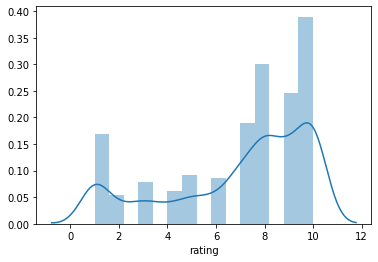

In [9]:
sns.distplot(Totaldata['rating'], bins=15)

## We choose 'efficiency' to be our target and we divide the 'rating' column into two classes: $0$ if the rating is below $7$ and $1$ otherwise, which we use as one of our features.

In [10]:
Totaldata['rating'] = (Totaldata['rating'] >6).astype(int)

### $\color{blue}{\text{10% of the data}}$

In [11]:
def get_data(data, percentage):
    Random=list(range(data.shape[0]))
    np.random.shuffle(Random)
    data=data.iloc[Random]
    return data.iloc[[i for i in range(int(percentage*len(data)))]]

In [12]:
ten_percent_data=get_data(Totaldata, 0.1)

ten_percent_data=ten_percent_data[['sideEffects', 'sideEffectsReview',\
                                   'commentsReview', 'rating', 'effectiveness']]
rating=ten_percent_data['rating']
ten_percent_data=ten_percent_data.drop('rating', axis=1)

In [13]:
Features=ten_percent_data.drop(['effectiveness'], axis=1)
Target=ten_percent_data['effectiveness']
Target=le().fit_transform(Target)

Dat=''
for col in Features.columns: 
    Dat += Features[col].map(str) + ' '

In [14]:
Dat.head()

881     Moderate Side Effects Basically, I only notice...
2356    Mild Side Effects Upset stomach, headache. Nau...
1044    Moderate Side Effects Made me nasuous, dizzy, ...
1004    Mild Side Effects I experienced drowsiness in ...
1189    Moderate Side Effects Chronic constipation, dr...
Name: sideEffects, dtype: object

In [15]:
Text_tranform=CountVectorizer(analyzer='word', max_features=100, stop_words='english', binary=True).fit(Dat)

In [16]:
Text_tranform.vocabulary_;

In [17]:
Numerical_features=Text_tranform.transform(Dat)
Numerical_features=Numerical_features.toarray()
Data=pd.DataFrame(Numerical_features) 

Data=pd.DataFrame(np.concatenate([rating.values.reshape(-1,1), Data], axis=1))
Data=pd.DataFrame(np.concatenate([Data, Target.reshape(-1,1)], axis=1))

In [18]:
Data.head()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,3
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,1,0,0,1,0,0,0,0,...,0,1,1,0,1,0,0,0,0,3
4,0,0,0,0,0,1,0,0,1,0,...,0,1,0,0,1,0,1,0,0,3


In [19]:
Train_features, Test_features, Train_target, Test_target = train_test_split(Data.iloc[:, :-1],\
        Data.iloc[:, -1], test_size=0.4, random_state=0)

$\color{blue}{Multiclass\ Logistic\ Regression}$

In [20]:
weights=np.ones((len(np.unique(Train_target)), 1+Train_features.shape[1]))

MultiLogReg=MulticlassLogReg(Max_iter=100, lr=0.3)

In [21]:
MultiLogReg.fit(Train_features, pd.Series(Train_target), weights)

  training: [=======================================100.0%=======================================]


In [22]:
Predict=MultiLogReg.predict(Test_features)

  predictions: [=====================================100.0%======================================]


In [41]:
set(Predict)

{0}

In [42]:
accuracy=(Test_target==Predict).sum()/len(Test_target)
print("Accuracy of Multiclass Logistic Regression: {}%".format(100*accuracy))

Accuracy of Multiclass Logistic Regression: 28.915662650602407%


$\color{blue}{Bernoulli\ Naive\ Bayes}$

In [26]:
NB=Naive_Bayes()

NB.train(Train_features, pd.Series(Train_target))

In [27]:
Pred=NB.predict(Test_features)

  predictions: [=====================================100.0%======================================]


In [28]:
accuracy=(Test_target==Pred).sum()/len(Test_target)
print("Accuracy of my Bernoulli Naive Bayes: {}%".format(100*accuracy))

Accuracy of my Bernoulli Naive Bayes: 43.373493975903614%


$\color{blue}{Gaussian\ Discriminant\ Analysis}$

In [29]:
GDA_Model=GDAMulticlass(regularizer=0.1)
GDA_Model.train(pd.DataFrame(Train_features), pd.Series(Train_target, name='target'))

  training: [=======================================100.0%=======================================]


In [30]:
GDA_Pred=GDA_Model.predict(pd.DataFrame(Test_features))

  predictions: [=====================================100.0%======================================]


In [31]:
accuracy=(Test_target==GDA_Pred).sum()/len(Test_target)
print("Accuracy of GDA: {}%".format(100*accuracy))

Accuracy of GDA: 45.78313253012048%


### $\color{blue}{\text{30% of the data}}$

In [32]:
thirty_percent_data=get_data(Totaldata, 0.3)

thirty_percent_data=thirty_percent_data[['sideEffects', 'sideEffectsReview', \
                                      'commentsReview', 'rating', 'effectiveness']]
rating=thirty_percent_data['rating']
thirty_percent_data=thirty_percent_data.drop('rating', axis=1)

Features=thirty_percent_data.drop(['effectiveness'], axis=1)
Target=thirty_percent_data['effectiveness']
Target=le().fit_transform(Target)

Dat=''
for col in Features.columns: 
    Dat += Features[col].map(str) + ' '

In [33]:
Text_tranform=CountVectorizer(analyzer='word', max_features=100, stop_words='english', binary=True).fit(Dat)

Text_tranform.vocabulary_;

Numerical_features=Text_tranform.transform(Dat)
Numerical_features=Numerical_features.toarray()
Data=pd.DataFrame(Numerical_features) 

Data=pd.DataFrame(np.concatenate([rating.values.reshape(-1,1), Data], axis=1))
Data=pd.DataFrame(np.concatenate([Data, Target.reshape(-1,1)], axis=1))

Data.head()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3
2,1,0,0,0,0,0,0,1,0,1,...,0,0,1,0,1,0,1,1,0,1
3,1,0,1,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [34]:
Train_features, Test_features, Train_target, Test_target = train_test_split(Data.iloc[:, :-1],\
        Data.iloc[:, -1], test_size=0.4, random_state=0)

$\color{blue}{Multiclass\ Logistic\ Regression}$

In [35]:
weights=np.ones((len(np.unique(Train_target)), 1+Train_features.shape[1]))

MultiLogReg=MulticlassLogReg(Max_iter=100, lr=0.3)

MultiLogReg.fit(Train_features, pd.Series(Train_target), weights)

  training: [=======================================100.0%=======================================]


In [36]:
Predict=MultiLogReg.predict(Test_features)

accuracy=(Test_target==Predict).sum()/len(Test_target)
print("Accuracy of Multiclass Logistic Regression: {}%".format(100*accuracy))

  predictions: [=====================================100.0%======================================]

Accuracy of Multiclass Logistic Regression: 44.46680080482898%


$\color{blue}{Bernoulli\ Naive\ Bayes}$

In [37]:
NB=Naive_Bayes()

NB.train(Train_features, pd.Series(Train_target))

In [38]:
Pred=NB.predict(Test_features)

accuracy=(Test_target==Pred).sum()/len(Test_target)
print("Accuracy of my Bernoulli Naive Bayes: {}%".format(100*accuracy))

  predictions: [=====================================100.0%======================================]

Accuracy of my Bernoulli Naive Bayes: 43.05835010060362%


$\color{blue}{Gaussian\ Discriminant\ Analysis}$

In [39]:
GDA_Model=GDAMulticlass(regularizer=0.01)
GDA_Model.train(pd.DataFrame(Train_features), pd.Series(Train_target, name='target'))

  training: [=======================================100.0%=======================================]


In [40]:
GDA_Pred=GDA_Model.predict(pd.DataFrame(Test_features))

accuracy=(Test_target==GDA_Pred).sum()/len(Test_target)
print("Accuracy of GDA: {}%".format(100*accuracy))

  predictions: [=====================================100.0%======================================]

Accuracy of GDA: 44.668008048289735%


### $\color{blue}{\text{60% of the data}}$

In [41]:
sixty_percent_data=get_data(Totaldata, 0.6)

sixty_percent_data=sixty_percent_data[['sideEffects', 'sideEffectsReview', 'commentsReview', 'rating', 'effectiveness']]
rating=sixty_percent_data['rating']
sixty_percent_data=sixty_percent_data.drop('rating', axis=1)



Features=sixty_percent_data.drop(['effectiveness'], axis=1)
Target=sixty_percent_data['effectiveness']
Target=le().fit_transform(Target)

Dat=''
for col in Features.columns: 
    Dat += Features[col].map(str) + ' '

In [42]:
Text_tranform=CountVectorizer(analyzer='word', max_features=100, stop_words='english', binary=True).fit(Dat)

Text_tranform.vocabulary_;

Numerical_features=Text_tranform.transform(Dat)
Numerical_features=Numerical_features.toarray()
Data=pd.DataFrame(Numerical_features) 

Data=pd.DataFrame(np.concatenate([rating.values.reshape(-1,1), Data], axis=1))
Data=pd.DataFrame(np.concatenate([Data, Target.reshape(-1,1)], axis=1))

Data.head();

In [43]:
Train_features, Test_features, Train_target, Test_target = train_test_split(Data.iloc[:, :-1],\
        Data.iloc[:, -1], test_size=0.4, random_state=0)

$\color{blue}{Multiclass\ Logistic\ Regression}$

In [44]:
weights=np.ones((len(np.unique(Train_target)), 1+Train_features.shape[1]))

MultiLogReg=MulticlassLogReg(Max_iter=100, lr=0.3)

MultiLogReg.fit(Train_features, pd.Series(Train_target), weights)


  training: [=======================================100.0%=======================================]


In [45]:
Predict=MultiLogReg.predict(Test_features)

accuracy=(Test_target==Predict).sum()/len(Test_target)
print("Accuracy of Multiclass Logistic Regression: {}%".format(100*accuracy))

  predictions: [=====================================100.0%======================================]


Accuracy of Multiclass Logistic Regression: 46.17706237424547%


$\color{blue}{Bernoulli\ Naive\ Bayes}$

In [46]:
NB=Naive_Bayes()

NB.train(Train_features, pd.Series(Train_target))

In [47]:
Pred=NB.predict(Test_features)

accuracy=(Test_target==Pred).sum()/len(Test_target)
print("Accuracy of my Bernoulli Naive Bayes: {}%".format(100*accuracy))

  predictions: [=====================================100.0%======================================]


Accuracy of my Bernoulli Naive Bayes: 45.87525150905433%


$\color{blue}{Gaussian\ Discriminant\ Analysis}$

In [48]:
GDA_Model=GDAMulticlass(regularizer=0.1)
GDA_Model.train(pd.DataFrame(Train_features), pd.Series(Train_target, name='target'))

  training: [=======================================100.0%=======================================]


In [49]:
GDA_Pred=GDA_Model.predict(pd.DataFrame(Test_features))

accuracy=(Test_target==GDA_Pred).sum()/len(Test_target)
print("Accuracy of GDA: {}%".format(100*accuracy))

  predictions: [=====================================100.0%======================================]

Accuracy of GDA: 48.08853118712273%


### $\color{blue}{\text{100% of the data}}$

In [50]:
whole_data=get_data(Totaldata, 1.0)

whole_data=whole_data[['sideEffects', 'sideEffectsReview', 'commentsReview', 'rating', 'effectiveness']]
rating=whole_data['rating']
whole_data=whole_data.drop('rating', axis=1)



Features=whole_data.drop(['effectiveness'], axis=1)
Target=whole_data['effectiveness']
Target=le().fit_transform(Target)

Dat=''
for col in Features.columns: 
    Dat += Features[col].map(str) + ' '


In [51]:
Text_tranform=CountVectorizer(analyzer='word', max_features=100, stop_words='english', binary=True).fit(Dat)

Text_tranform.vocabulary_;

Numerical_features=Text_tranform.transform(Dat)
Numerical_features=Numerical_features.toarray()
Data=pd.DataFrame(Numerical_features) 

#Data=pd.DataFrame(np.concatenate([rating.values.reshape(-1,1), Data], axis=1))
Data=pd.DataFrame(np.concatenate([Data, Target.reshape(-1,1)], axis=1))

Data.head();


In [52]:
Train_features, Test_features, Train_target, Test_target = train_test_split(Data.iloc[:, :-1],\
        Data.iloc[:, -1], test_size=0.4, random_state=0)

$\color{blue}{Multiclass\ Logistic\ Regression}$

In [53]:
weights=np.ones((len(np.unique(Train_target)), 1+Train_features.shape[1]))

MultiLogReg=MulticlassLogReg(Max_iter=100, lr=0.3)

MultiLogReg.fit(Train_features, pd.Series(Train_target), weights)


  training: [=======================================100.0%=======================================]


In [54]:
Predict=MultiLogReg.predict(Test_features)

accuracy=(Test_target==Predict).sum()/len(Test_target)
print("Accuracy of Multiclass Logistic Regression: {}%".format(100*accuracy))

  predictions: [=====================================100.0%======================================]

Accuracy of Multiclass Logistic Regression: 41.61640530759952%


$\color{blue}{Bernoulli\ Naive\ Bayes}$

In [55]:
NB=Naive_Bayes()

NB.train(Train_features, pd.Series(Train_target))

In [56]:
Pred=NB.predict(Test_features)

accuracy=(Test_target==Pred).sum()/len(Test_target)
print("Accuracy of my Bernoulli Naive Bayes: {}%".format(100*accuracy))

  predictions: [=====================================100.0%======================================]

Accuracy of my Bernoulli Naive Bayes: 39.56574185765983%


$\color{blue}{Gaussian\ Discriminant\ Analysis}$

In [57]:
GDA_Model=GDAMulticlass(regularizer=0.1)
GDA_Model.train(pd.DataFrame(Train_features), pd.Series(Train_target, name='target'))

  training: [=======================================100.0%=======================================]


In [58]:
GDA_Pred=GDA_Model.predict(pd.DataFrame(Test_features))

accuracy=(Test_target==GDA_Pred).sum()/len(Test_target)
print("Accuracy of GDA: {}%".format(100*accuracy))

  predictions: [=====================================100.0%======================================]

Accuracy of GDA: 42.5211097708082%


## Comparison using the Iris data

In [59]:
from sklearn import datasets
iris=datasets.load_iris()

x=iris.data[:,:4]
y=(iris.target)

In [60]:
x_train, x_test, y_train, y_test = train_test_split(x,\
        y, test_size=0.8, random_state=101)

$\color{blue}{Multiclass\ Logistic\ Regression}$

In [61]:
weights=np.zeros((len(np.unique(y)), 1+x.shape[1]))

MultiLogReg=MulticlassLogReg(Max_iter=400, lr=0.2)

MultiLogReg.fit(pd.DataFrame(x_train), pd.Series(y_train), weights)

  training: [=======================================100.0%=======================================]


In [62]:
Ypred=MultiLogReg.predict(x_test)

  predictions: [=====================================100.0%======================================]


In [63]:
("Accuracy of Logistic regression: {}%" .format(100*(Ypred==y_test).sum()/len(y_test)))

'Accuracy of Logistic regression: 97.5%'

$\color{blue}{Bernoulli\ Naive\ Bayes}$

In [64]:
NaiveB=Naive_Bayes()
NaiveB.train(pd.DataFrame(x_train), pd.Series(y_train))

In [65]:
Y1pred=NaiveB.predict(pd.DataFrame(x_test))

  predictions: [=====================================100.0%======================================]


In [66]:
print('Accuracy of Naive Bayes: {}%' .format (100*(Y1pred==y_test).sum()/len(y_test)))

Accuracy of Naive Bayes: 35.833333333333336%


$\color{blue}{Gaussian\ Discriminant\ Analysis}$

In [67]:
GDA2=GDAMulticlass()
GDA2.train(pd.DataFrame(x_train), pd.Series(y_train, name='target'))

  training: [=======================================100.0%=======================================]


In [68]:
Y2Pred=GDA2.predict(pd.DataFrame(x_test))

  predictions: [=====================================100.0%======================================]


In [69]:
print("Accuracy of GDA: {}%" .format(100*(Y2Pred==y_test).sum()/len(y_test)))

Accuracy of GDA: 98.33333333333333%


### We download another data to compare the three models.

In [70]:
#!wget https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv

In [71]:
Text=pd.read_csv("bbc-text.csv")
Text.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [72]:
Text.text[0]

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

In [74]:
Text_tranformer=CountVectorizer(analyzer='word', max_features=400, binary=True).fit(Text['text'])

bow1=Text_tranformer.transform(Text['text'])

In [75]:
Data=pd.DataFrame(data=bow1.toarray())
Data.head()
Text['category']=le().fit_transform(Text['category'])
Data['target']=Text['category']

In [76]:
Train_features, Test_features, Train_target, Test_target = train_test_split(Data.iloc[:, :-1],\
        Data.iloc[:, -1], test_size=0.4, random_state=101)

$\color{blue}{Multiclass\ Logistic\ Regression}$

In [77]:
weights=np.ones((len(np.unique(Train_target)), 1+Train_features.shape[1]))

MultiLogReg=MulticlassLogReg(Max_iter=100, lr=0.2)

MultiLogReg.fit(Train_features, Train_target, weights)

  training: [=======================================100.0%=======================================]


In [78]:
Predict=MultiLogReg.predict(Test_features)
AccuracyLogRegression=(Predict==Test_target).sum()/(len(Test_target))
print("Accuracy of the Logistic-Regression: ", AccuracyLogRegression*100)

  predictions: [=====================================100.0%======================================]

Accuracy of the Logistic-Regression:  93.14606741573034


$\color{blue}{Bernoulli\ Naive\ Bayes}$

In [79]:
NB=Naive_Bayes()

NB.train(Train_features, Train_target)

In [80]:
Pred=NB.predict(Test_features)

accuracy=(np.array(Test_target)==Pred).sum()/len(Test_target)
print("Accuracy Naive Bayes: {}%".format(100*accuracy))

  predictions: [=====================================100.0%======================================]

Accuracy Naive Bayes: 86.62921348314607%


$\color{blue}{Gaussian\ Discriminant\ Analysis}$

In [81]:
MulticlassGDA=GDAMulticlass()

MulticlassGDA.train(Train_features, Train_target)

  training: [=======================================100.0%=======================================]


In [82]:
GDA_Pred=MulticlassGDA.predict(Test_features)

AccuracyGDA=(np.array(Test_target)==GDA_Pred).sum()/len(Test_target)
print("Accuracy of the GDA: ", AccuracyGDA*100)

  predictions: [=====================================100.0%======================================]

Accuracy of the GDA:  93.37078651685393


## $\color{green}{\text{Report}}$

The three algorithms GDA, Naive Bayes and Softmax Logistic Regression were compared on three different data sets: 'drugLib_raw.tsv', Iris data set and 'bbc-text.csv'.
The comparison on the first data set 'drugLib_raw.tsv' was done in four steps: comparison on $10\%$, $30\%$, $60\%$ and finally on $100\%$ of the data. On these four comparisons, GDA appeared to be the most accurate (even though the accuracy was around $45\%$ in average), followed very closely by Softmax Logistic Rgression. But it is important to underline that Naive Bayes and GDA are very fast (during the training process) as compared to Softmax Logistic Regression. This is due to the fact that GDA and Naive Bayes are both generative models and don't require any learning algorithm, their parameters are directly computed, no update required. On the other side, the low accuracy observed on the three algorithms is probably due to the fact that the features used are not predictive enough for the target chosen.



On Iris data set (small data set), very good accuracy was observed but only on two of the three algorithms. Again, GDA and Softmax Logistic Regression were the best ($98.33\%$ vs $97.5\%$), whereas Naive Bayes gave $35.83\%$ accuracy. The failure of Naive Bayes (actually Bernoulli Naive Bayes) on this example is due to the fact that features were not binary.

On the third data set, which also is as big as the first one, we observed good accuracy for the three algorithms. On this particular data set, Softmax was slightly less accurate as compared to GDA ($93.15\%$ vs $93.37\%$) and Naive Bayes scored $86.63\%$.


In conclusion, each of the three algorithms is unique and reliable depending on which data we are investigating. The two generative models GDA and Naive Bayes are fast but can give bad results if the (strong) assumptions they are made of are not met. On the other side, Softmax Logistic Regression takes time to train, but is more stable as it uses fewer assumptions and can handle both binary and non-binary features.